In [1]:
import vnstock as vns
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from MFI import mfi
from RSI import rsi
import time


In [2]:
ticker = 'FPT'

In [3]:
df = vns.stock_historical_data(symbol = ticker, start_date="2014-01-01", 
                            end_date='2024-06-01', resolution='1D', type='stock')


In [4]:

def calculate_indicators(data, ticker):
    data['mfi'] = mfi(data)

    data = data[['time', 'close', 'mfi']]
    data.set_index('time', inplace = True)
    data.columns = [ticker, 'mfi']
    data = data.dropna()

    data['sma10'] = data[ticker].rolling(window = 10, min_periods = 1).mean()
    
    data['sma50'] = data[ticker].rolling(window = 50, min_periods = 1).mean()
    
    data['ema'] = data[ticker].ewm(span = 10).mean()
    
    data['rsi'] = rsi(data, ticker)

    return data.dropna()


In [5]:
df = calculate_indicators(df, ticker)

In [6]:
df

,FPT,mfi,sma10,sma50,ema,rsi
time,,,,,,
2014-01-15,7060,92.937360,6827.0,6827.000000,6892.231990,84.905660
2014-01-16,7130,94.040055,6871.0,6854.545455,6940.805022,86.666667
2014-01-17,7270,95.064683,6930.0,6889.166667,7006.577576,90.410959
2014-01-20,7340,95.630284,6986.0,6923.846154,7072.018146,90.000000
2014-01-21,7490,95.969992,7064.0,6964.285714,7152.886497,100.000000
...,...,...,...,...,...,...
2024-05-27,114690,41.084470,116045.0,104621.000000,115261.585431,57.710012
2024-05-28,118320,42.923023,116607.0,104966.600000,115817.660807,63.828740
2024-05-29,117190,46.534471,116745.0,105289.600000,116067.177024,53.762268


In [7]:
length_data = len(df)    
length_train = round(length_data * 0.6)  
length_validation = round(length_data * 0.2)  
length_test = length_data - length_train - length_validation

#Validation set is for tuning parameters and test set is for actual testing

In [8]:
train_data = df[:length_train]
validation_data = df[length_train:length_train+length_validation]
test_data = df[length_train+length_validation:]

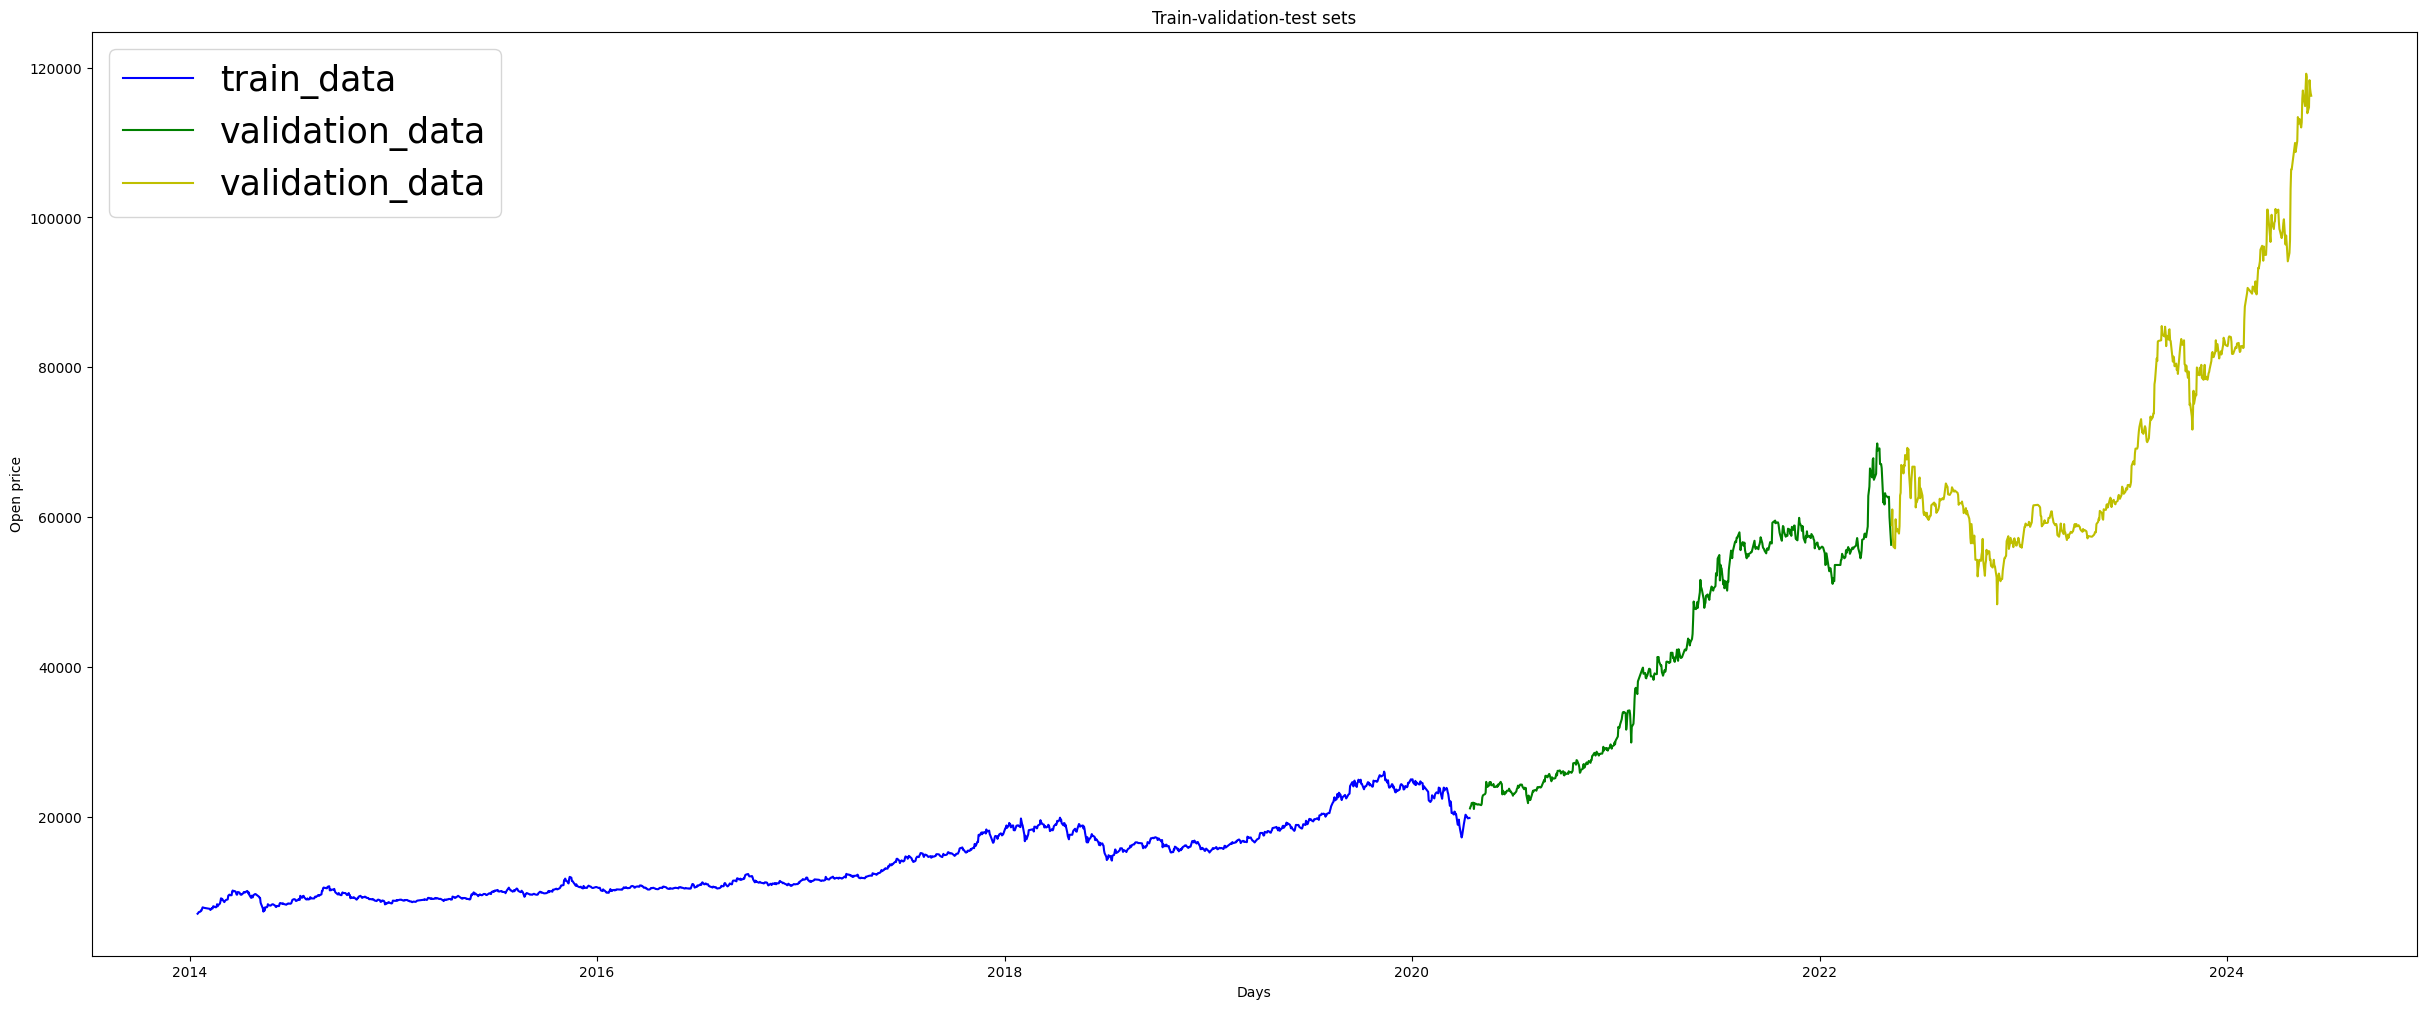

In [9]:
indicator = ticker

plt.subplots(figsize =(30,12))
plt.plot(train_data.index, train_data[indicator], label = "train_data", color = "b")
plt.plot(validation_data.index, validation_data[indicator], label = "validation_data", color = "g")
plt.plot(test_data.index, test_data[indicator], label = "validation_data", color = "y")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Train-validation-test sets")
plt.legend(fontsize = 25)
plt.show()

In [93]:
df_diff = df.iloc[1000:].diff(1)
df_diff.iloc[0] = 0

In [94]:
def calculate_MSE(df_temp1, df_temp2):
    return ((df_temp1.values - df_temp2.values)**2).sum()

def pattern_matching(df, start, window):
    df_temp = df['ema'].copy()
    if (start + window >= len(df_temp)) or (start < window):
        return 'Range not found'
    df_window = df_temp.iloc[start:start + window]
    df_window -= df_window.iloc[0]
    MSEs = []
    for i in range(start - window):
        df_compare = df_temp.iloc[i:i+window]
        df_compare -= df_compare.iloc[0]
        MSEs.append(calculate_MSE(df_window, df_compare))
    # return MSEs.index(min(MSEs))
    return MSEs.index(min(MSEs))

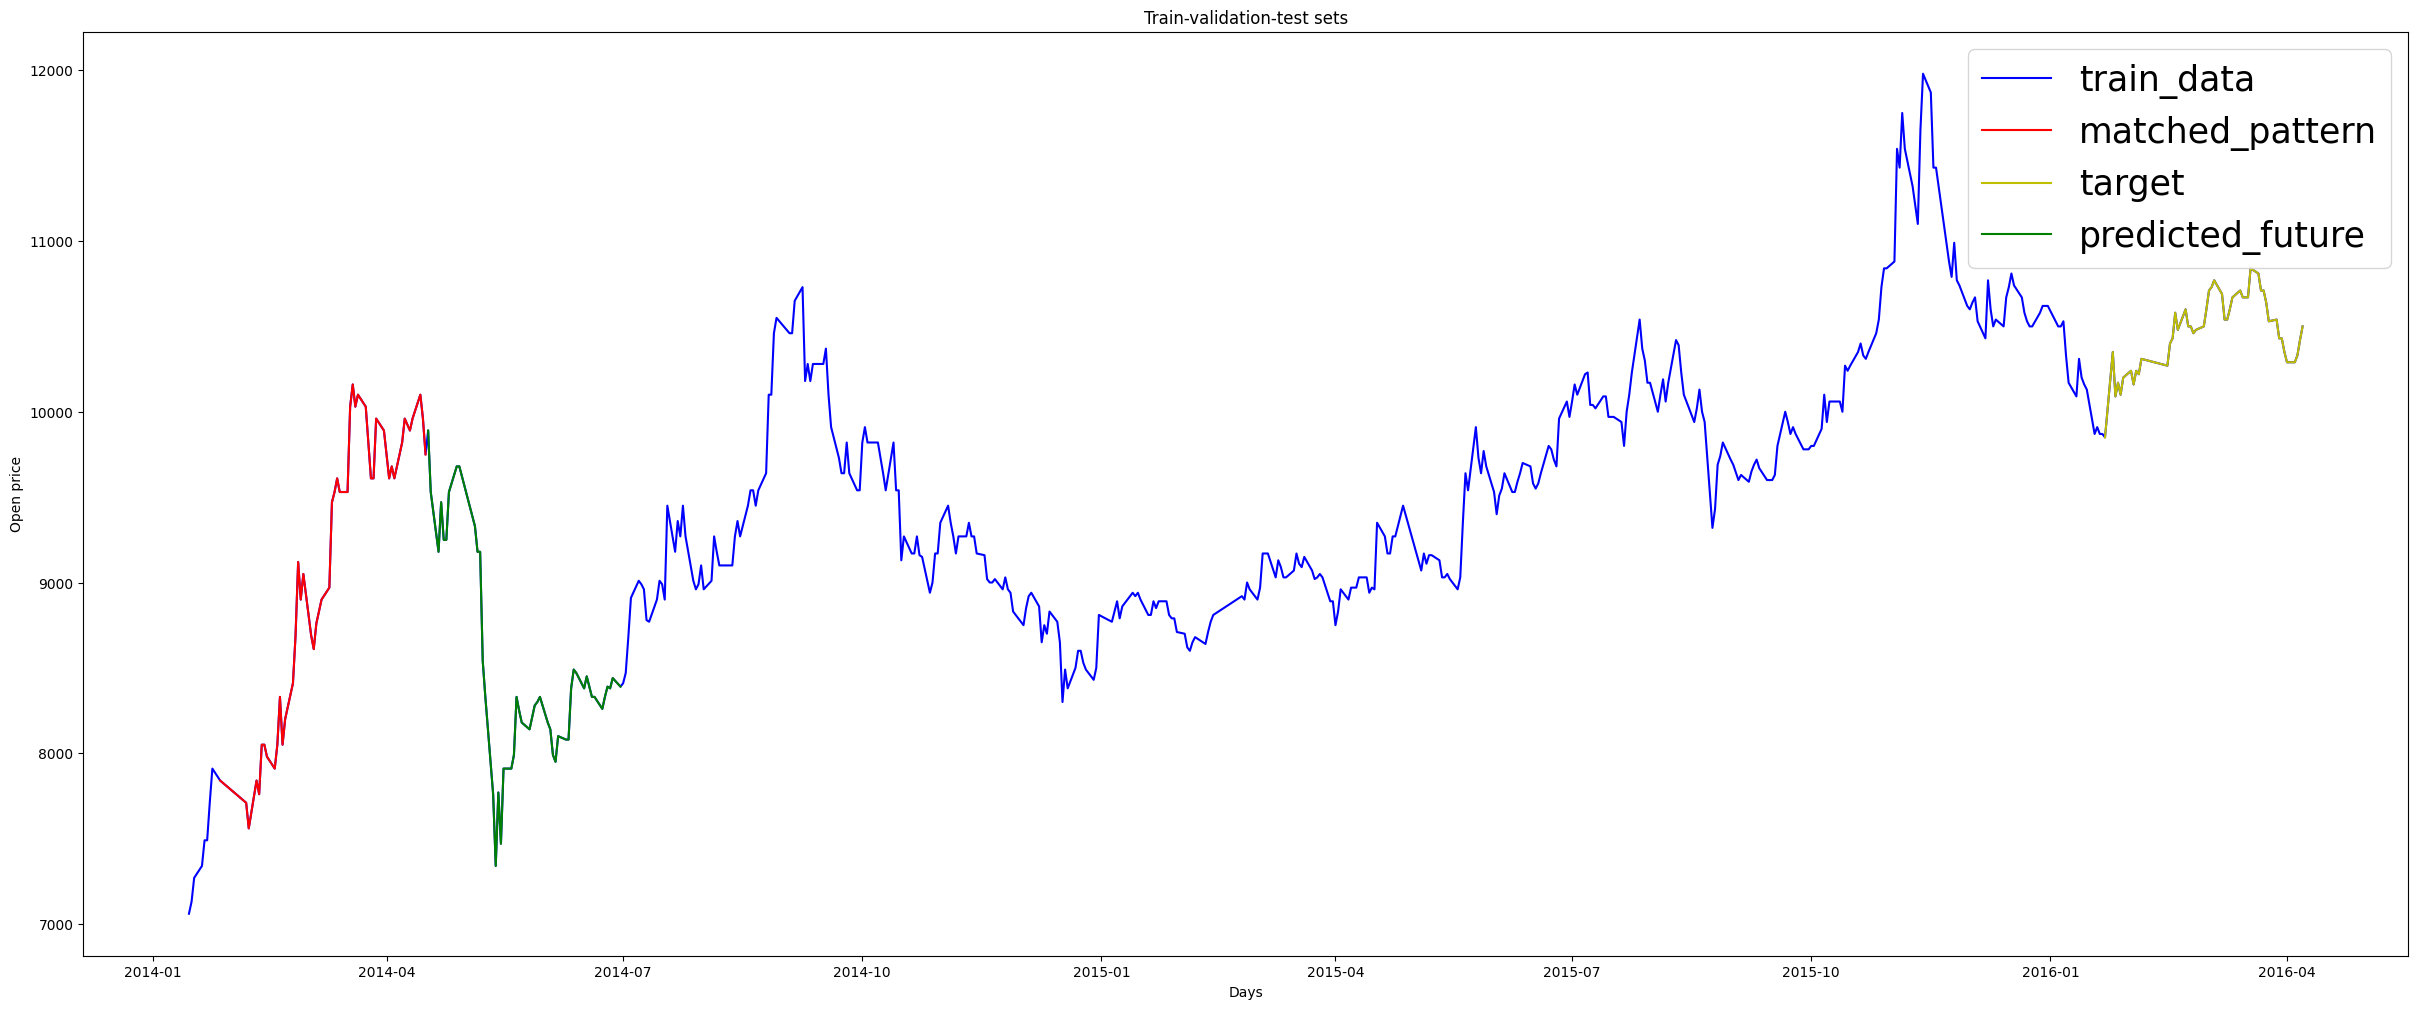

Predicted profit/loss is : -1360


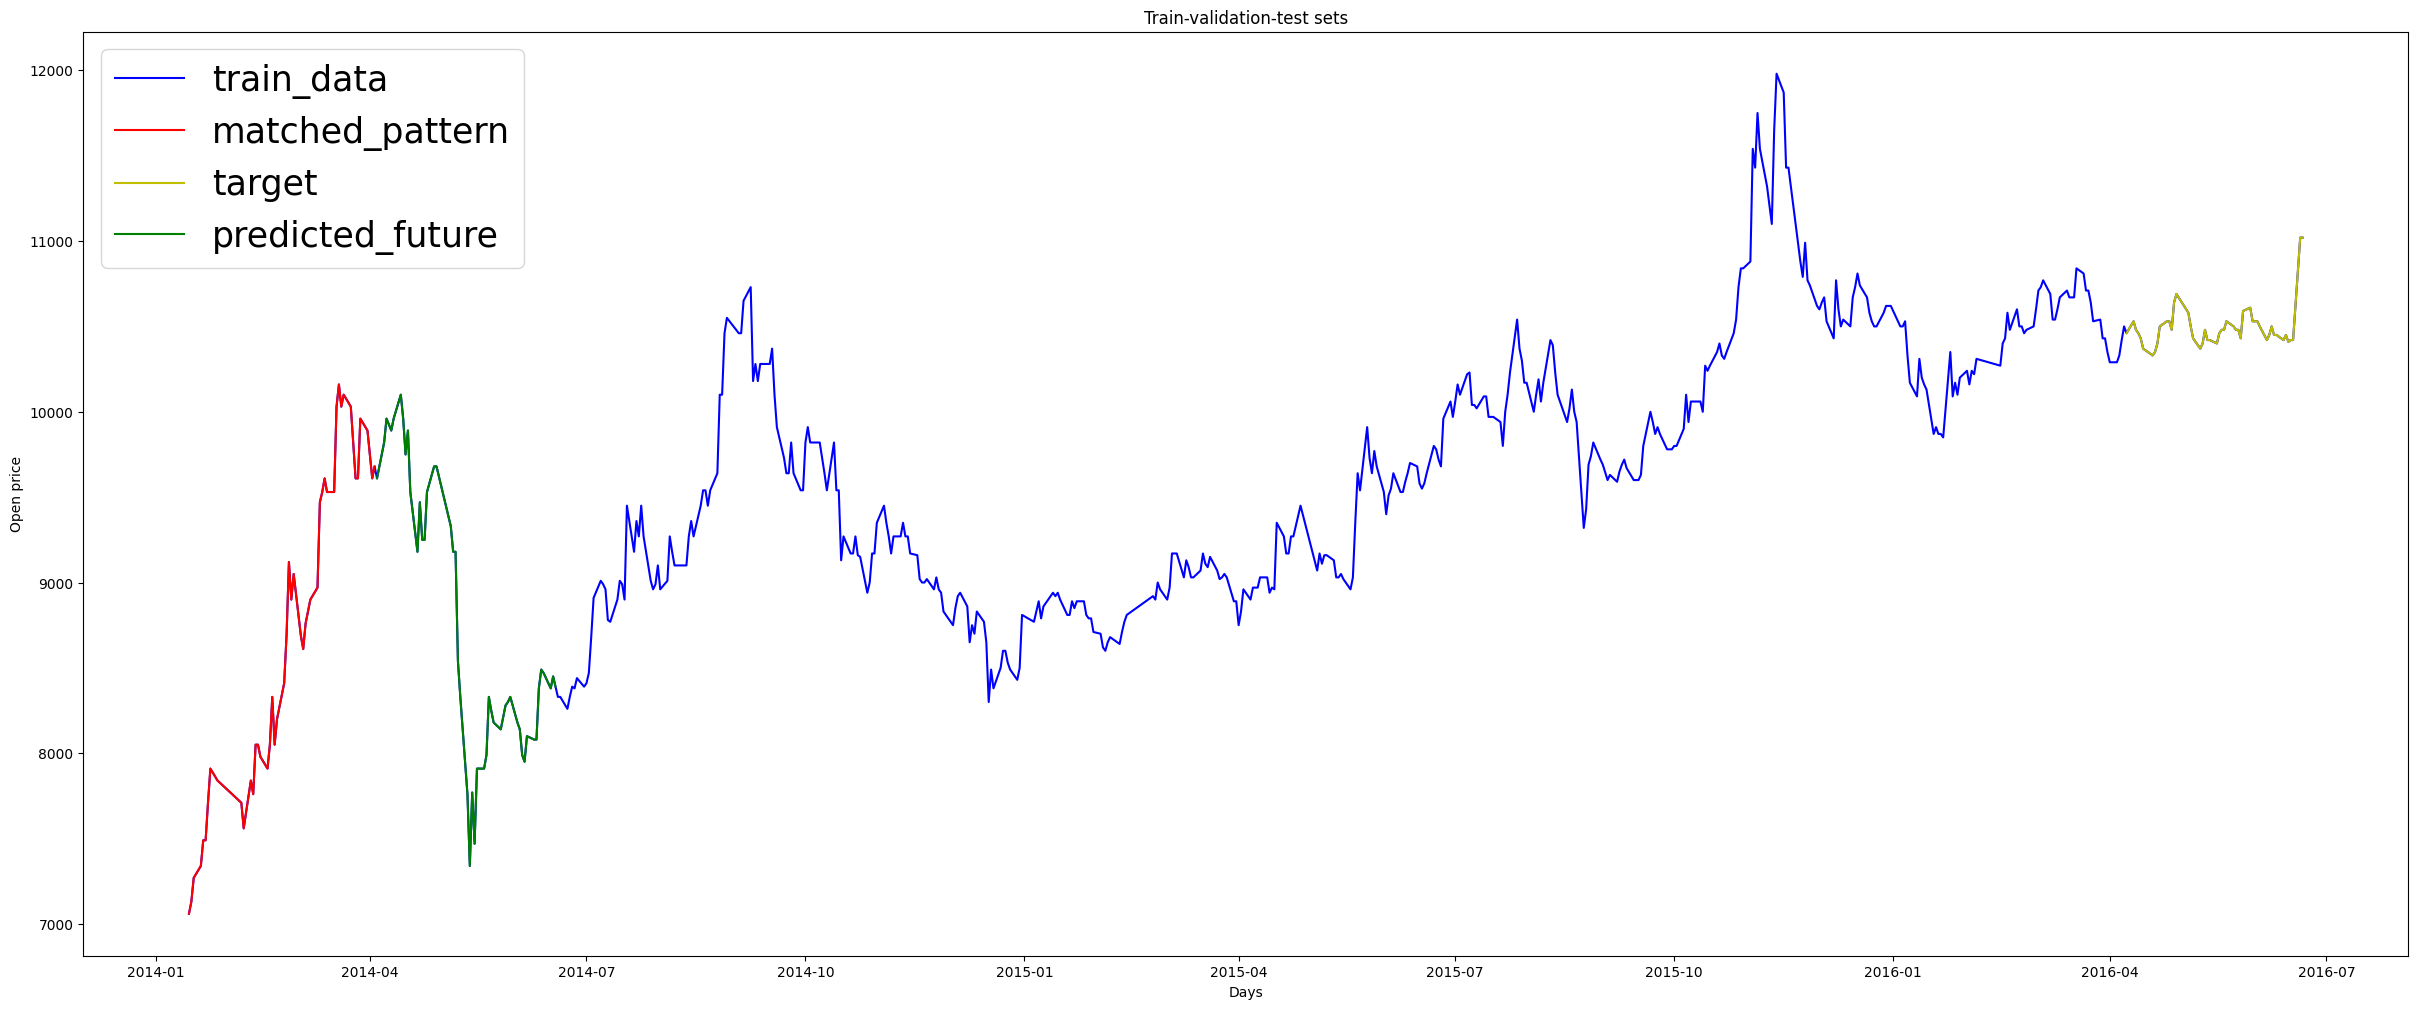

Predicted profit/loss is : -1290


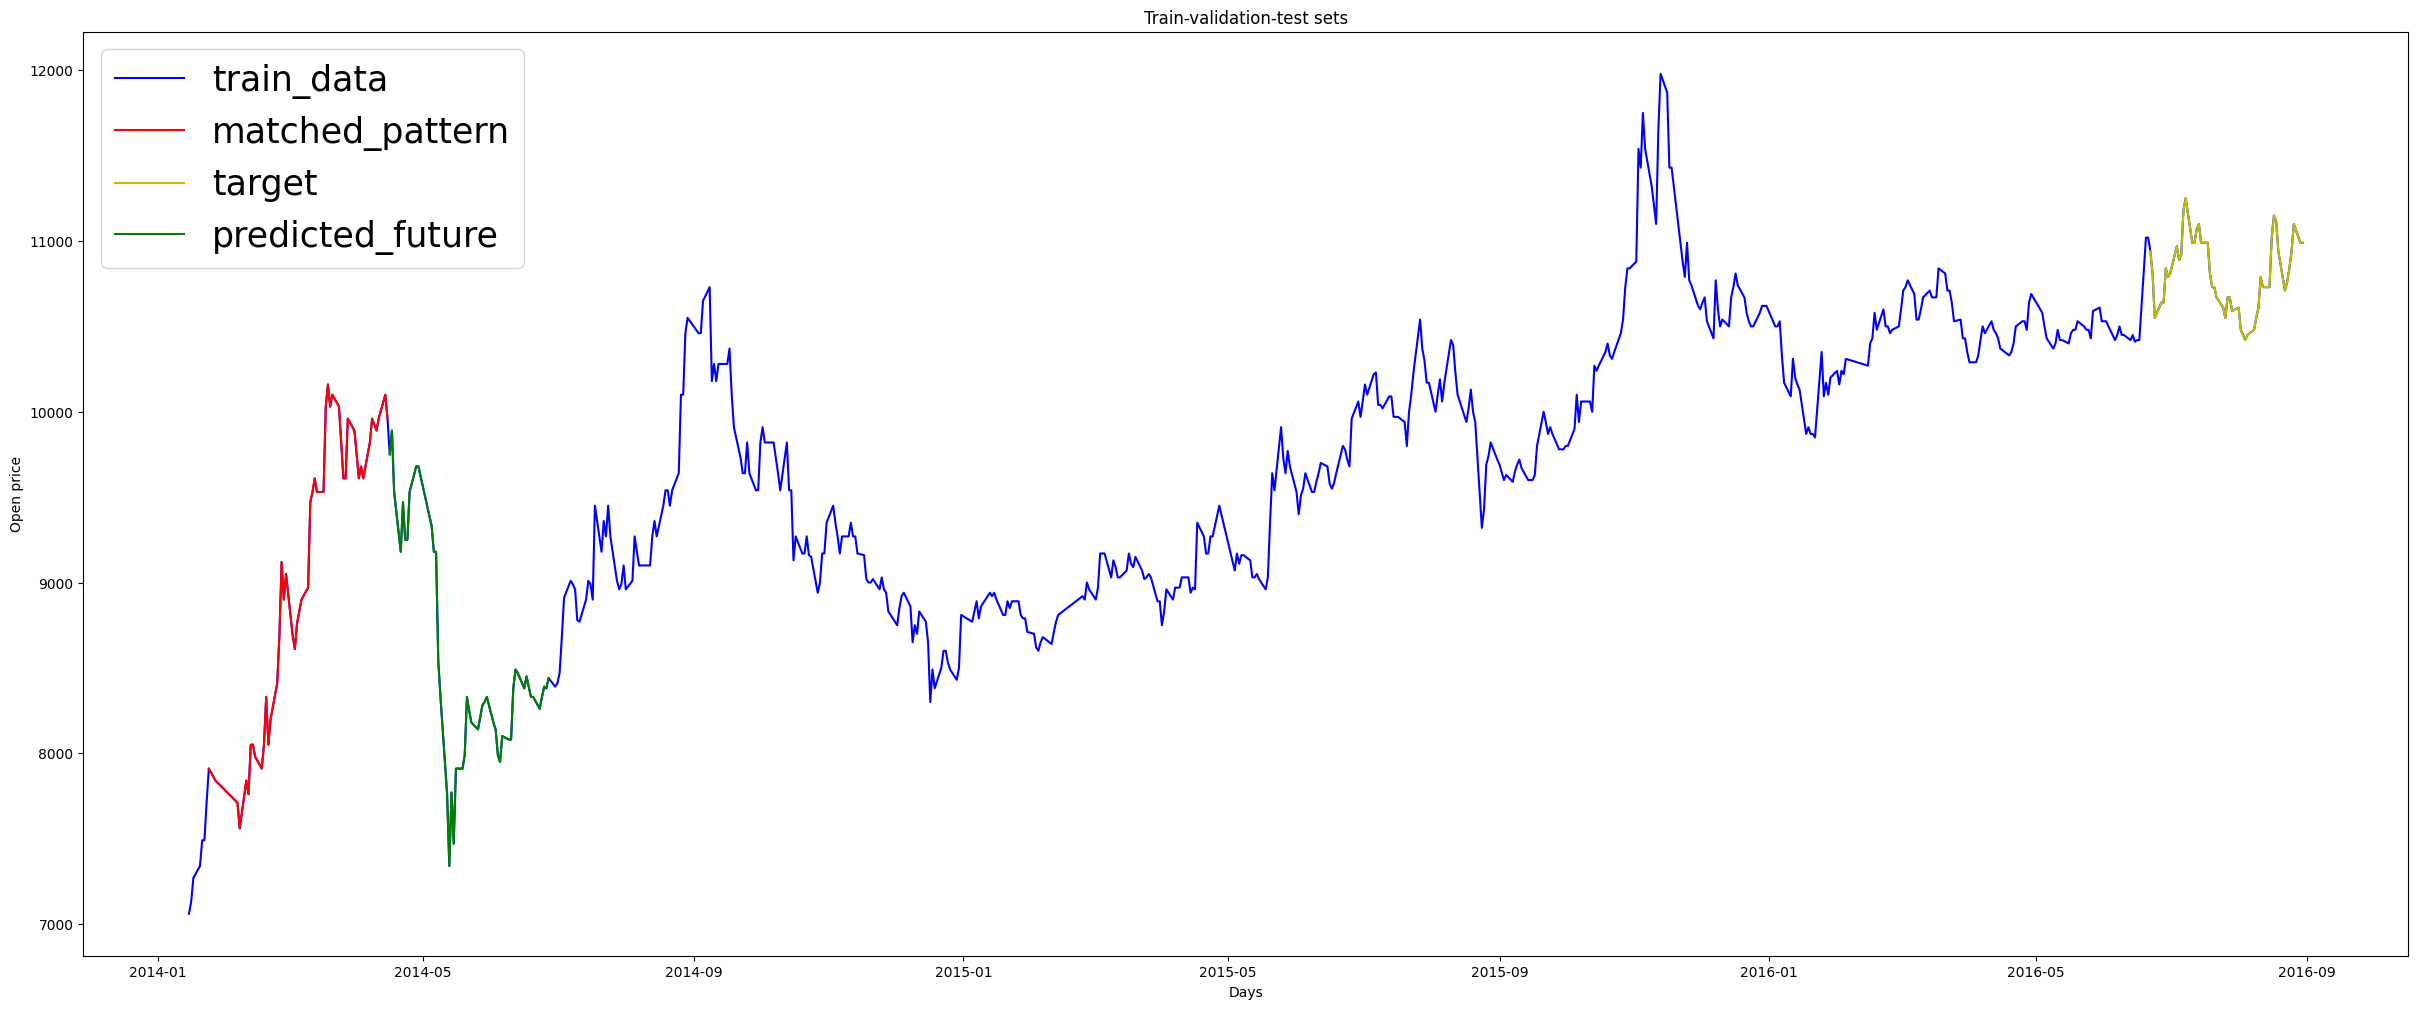

Predicted profit/loss is : -1520


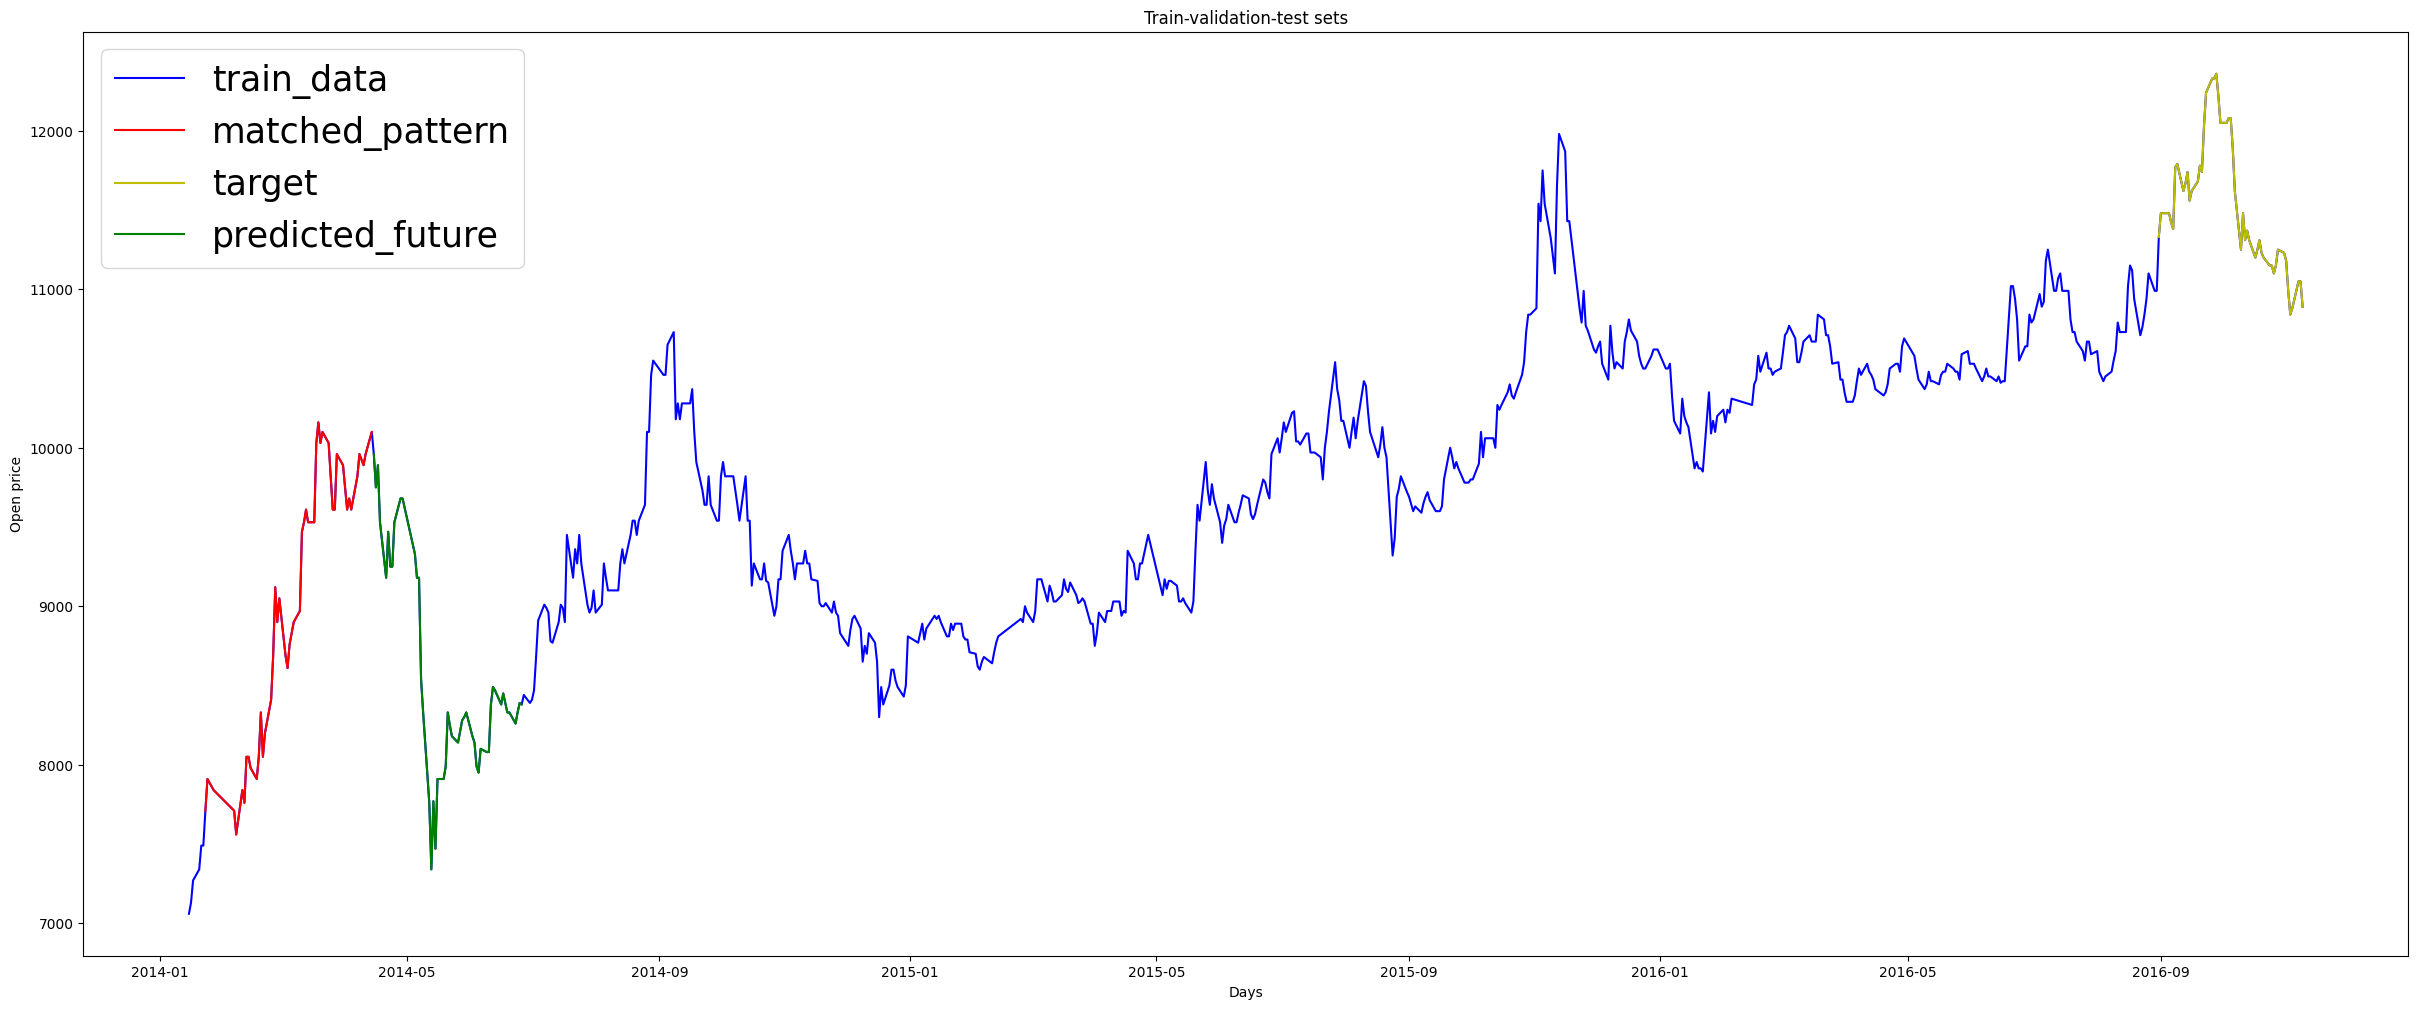

Predicted profit/loss is : -1720


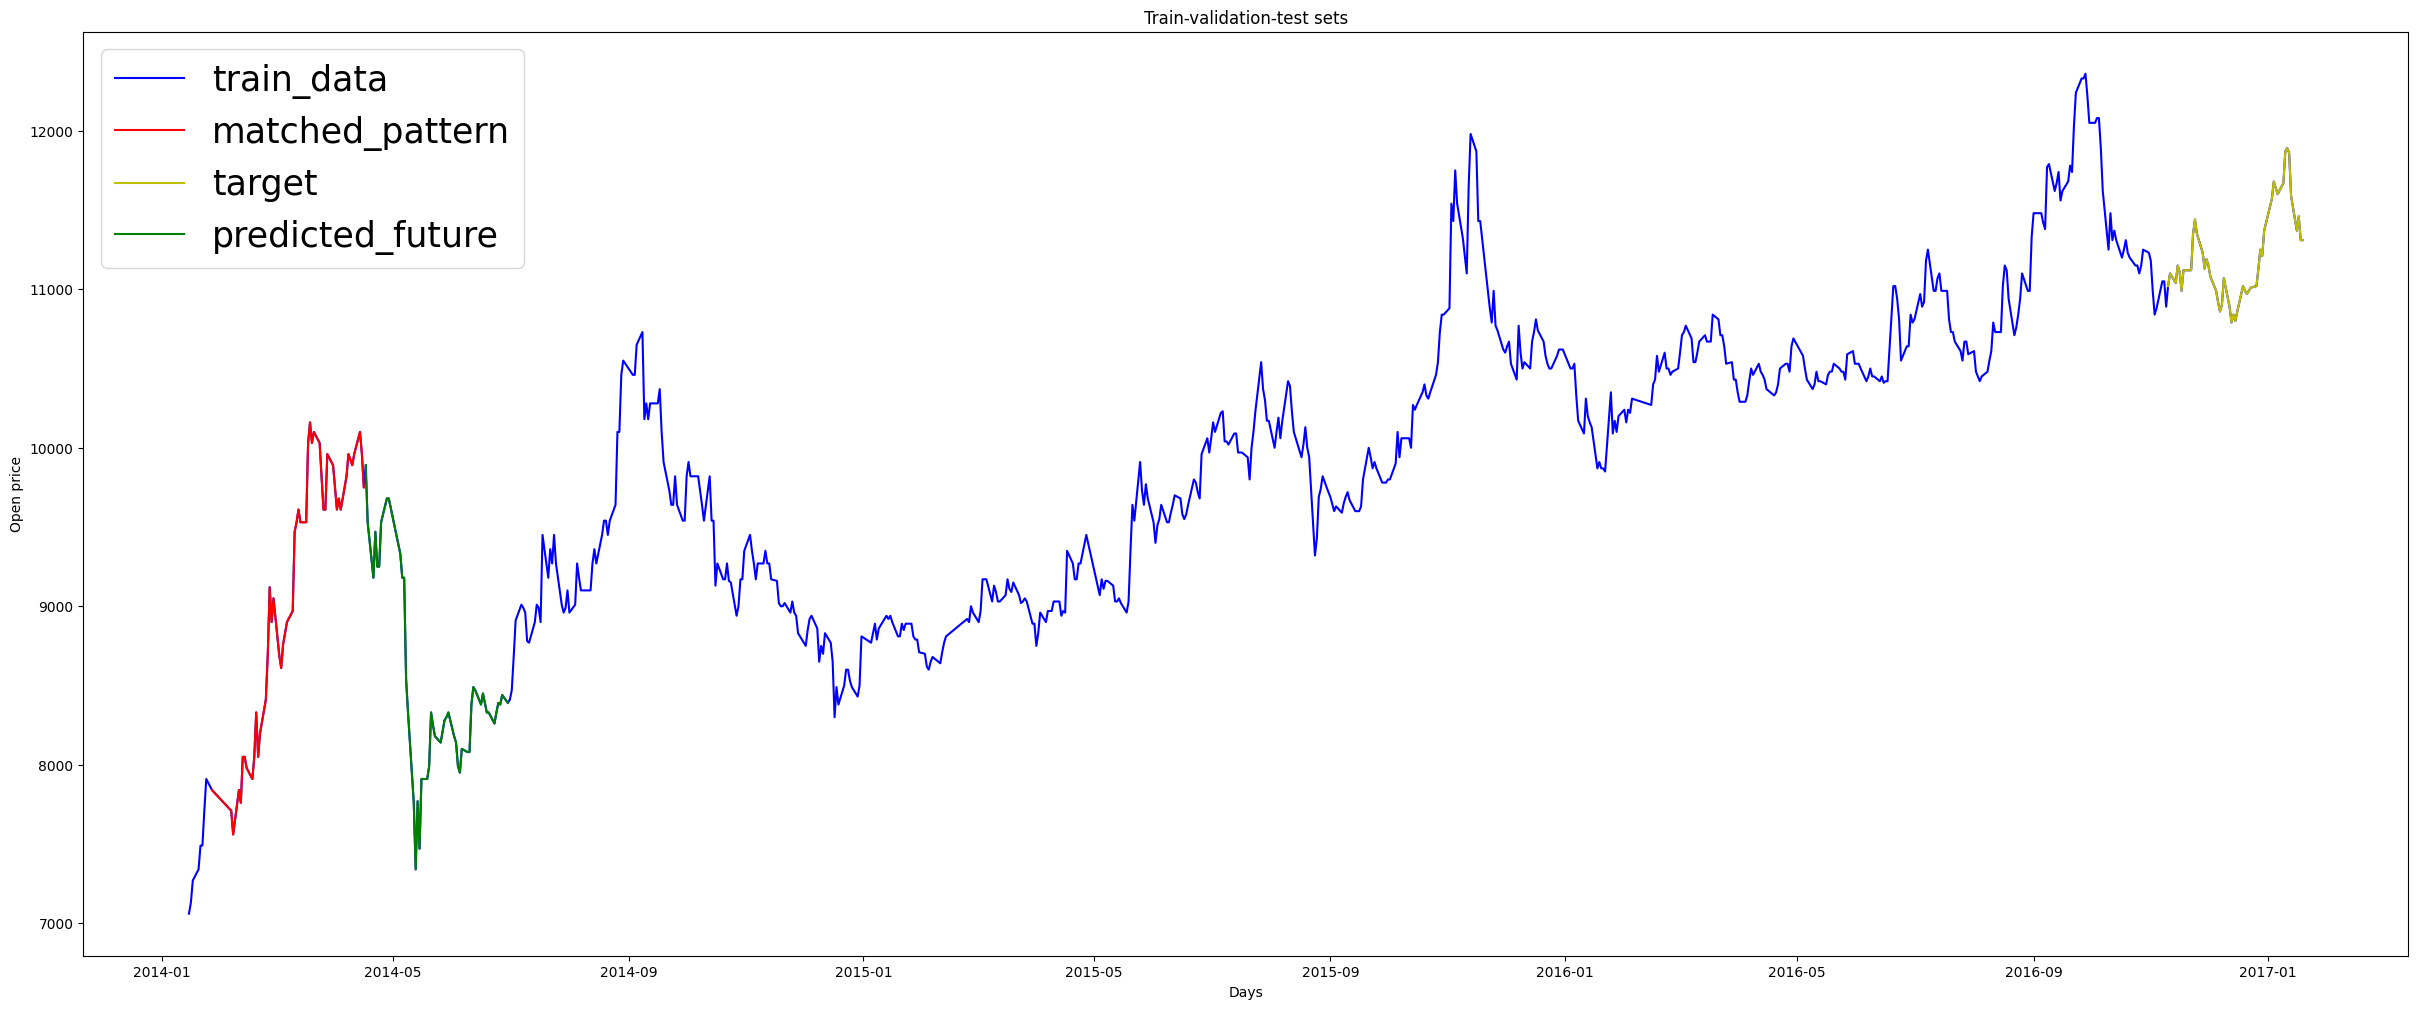

Predicted profit/loss is : -1360


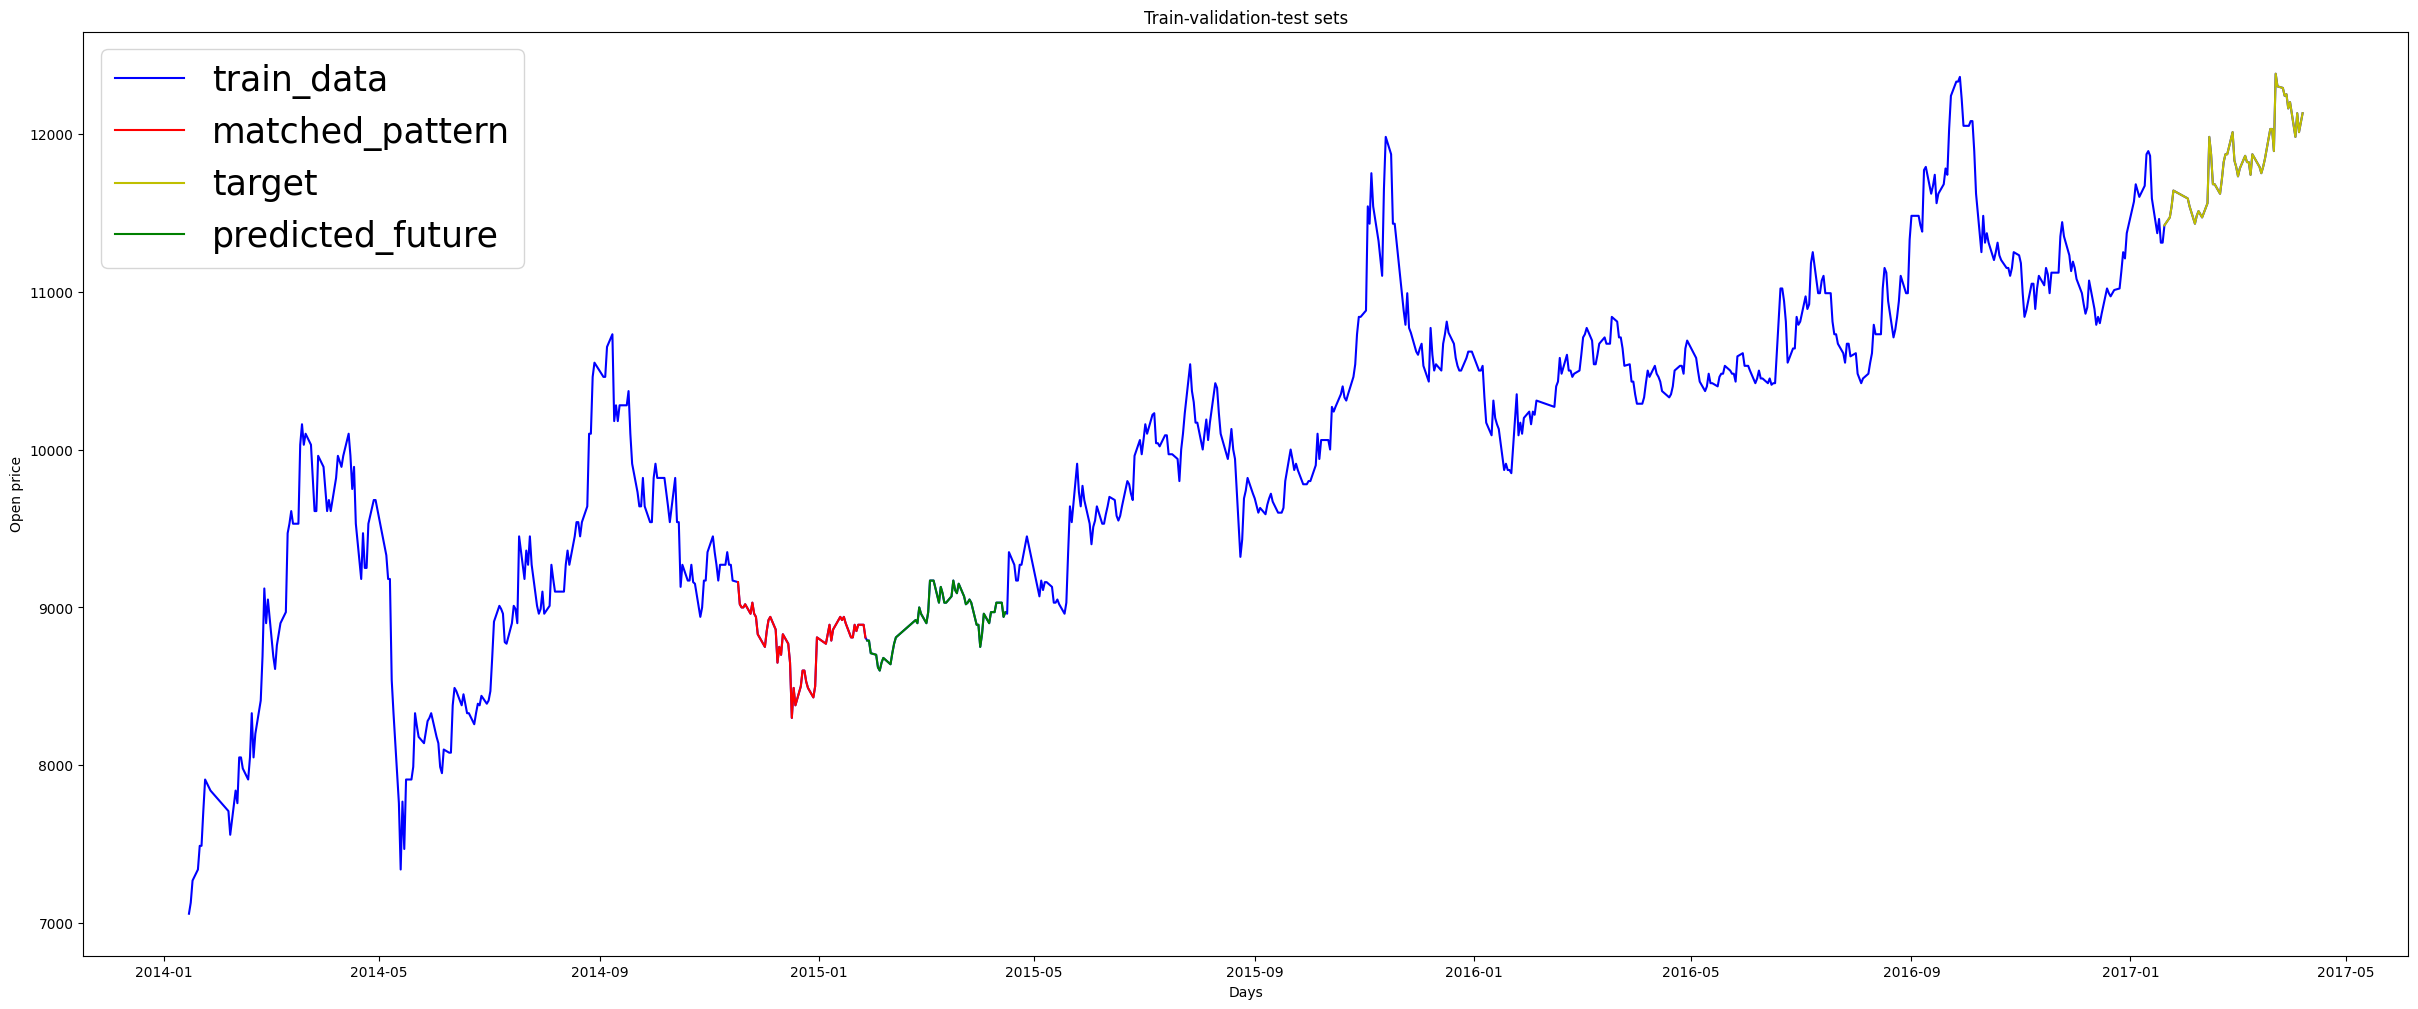

Predicted profit/loss is : 160


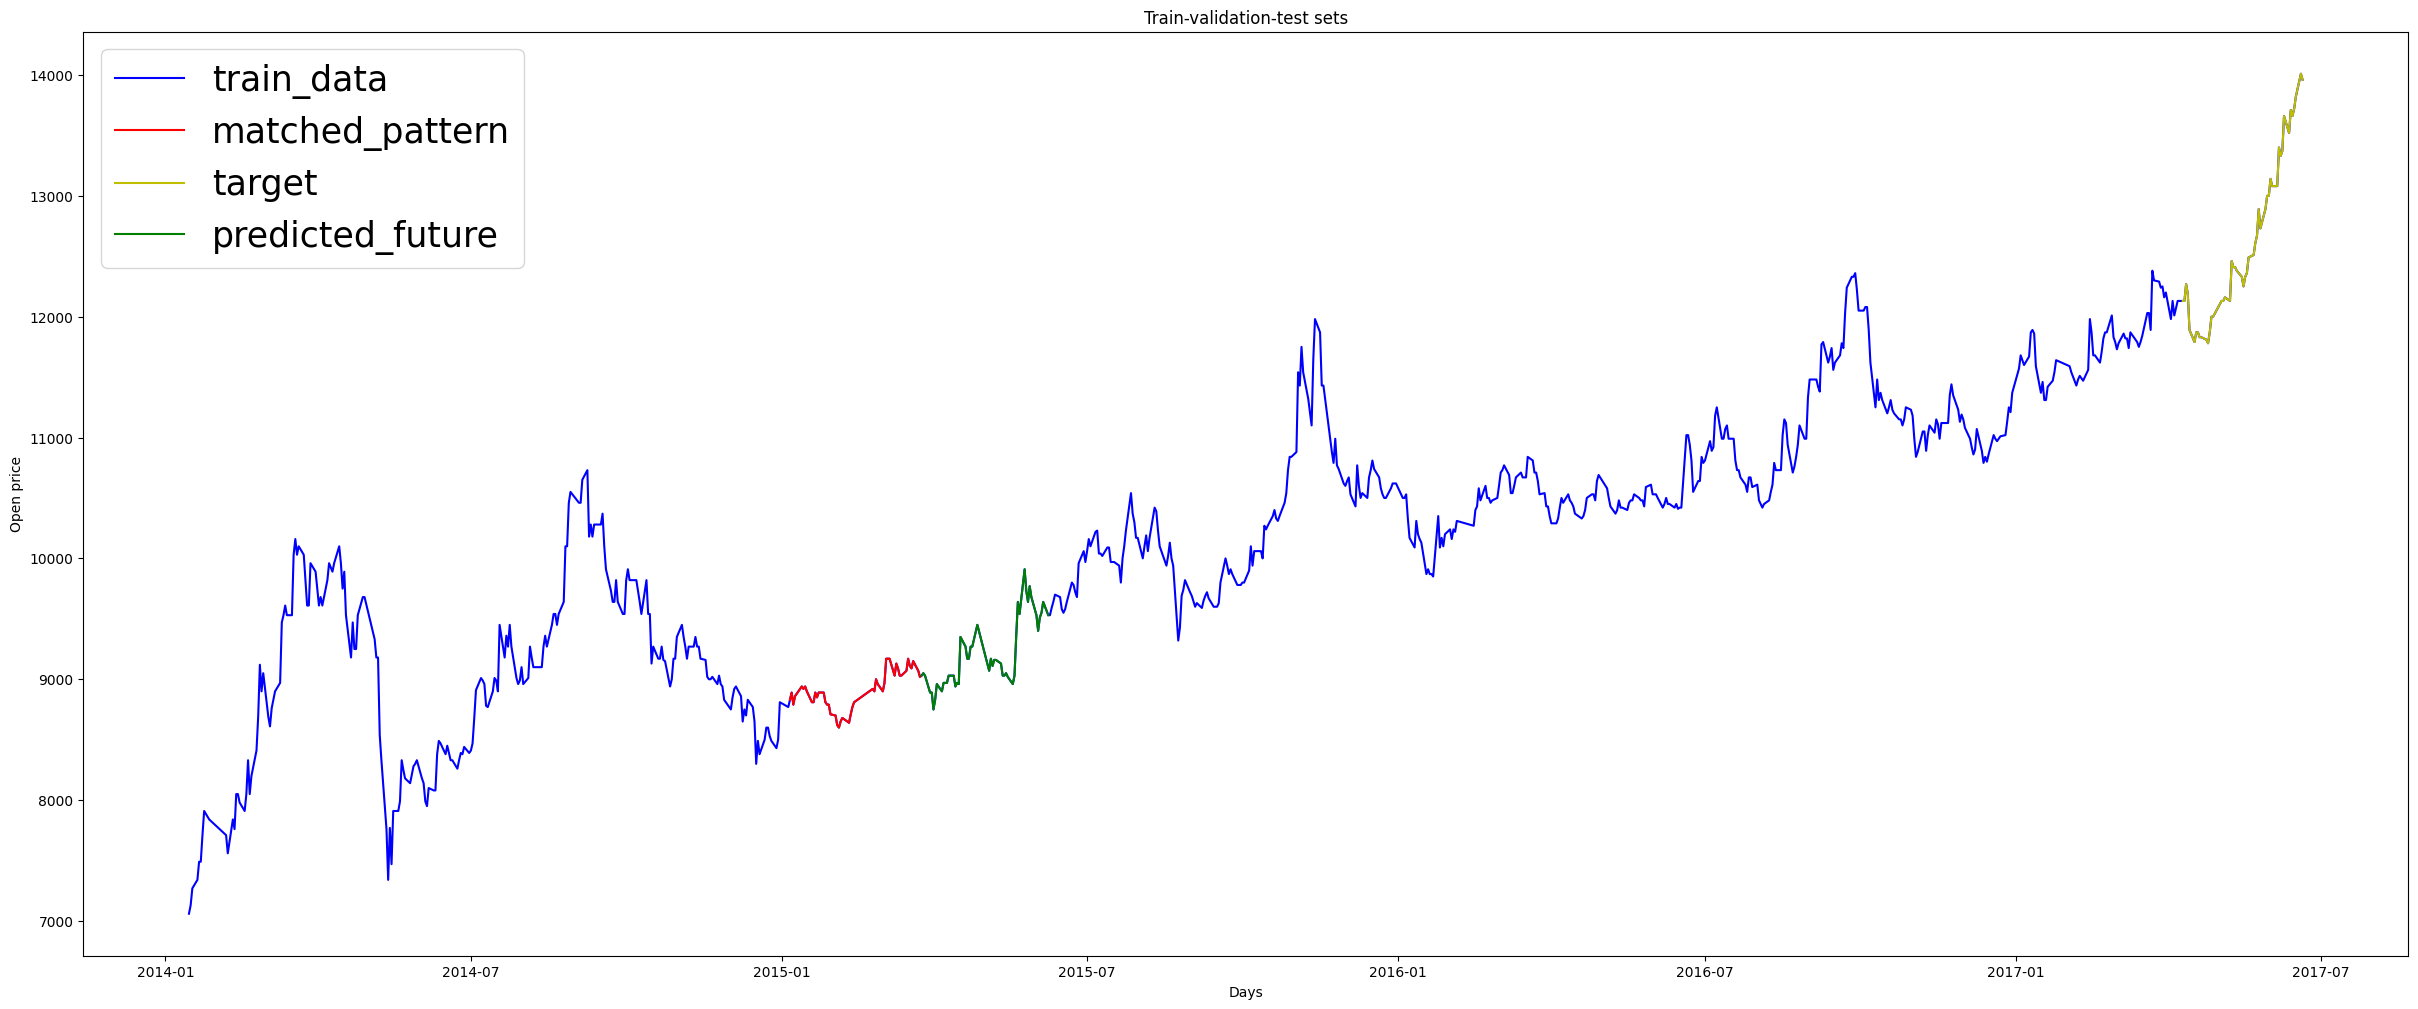

Predicted profit/loss is : 510


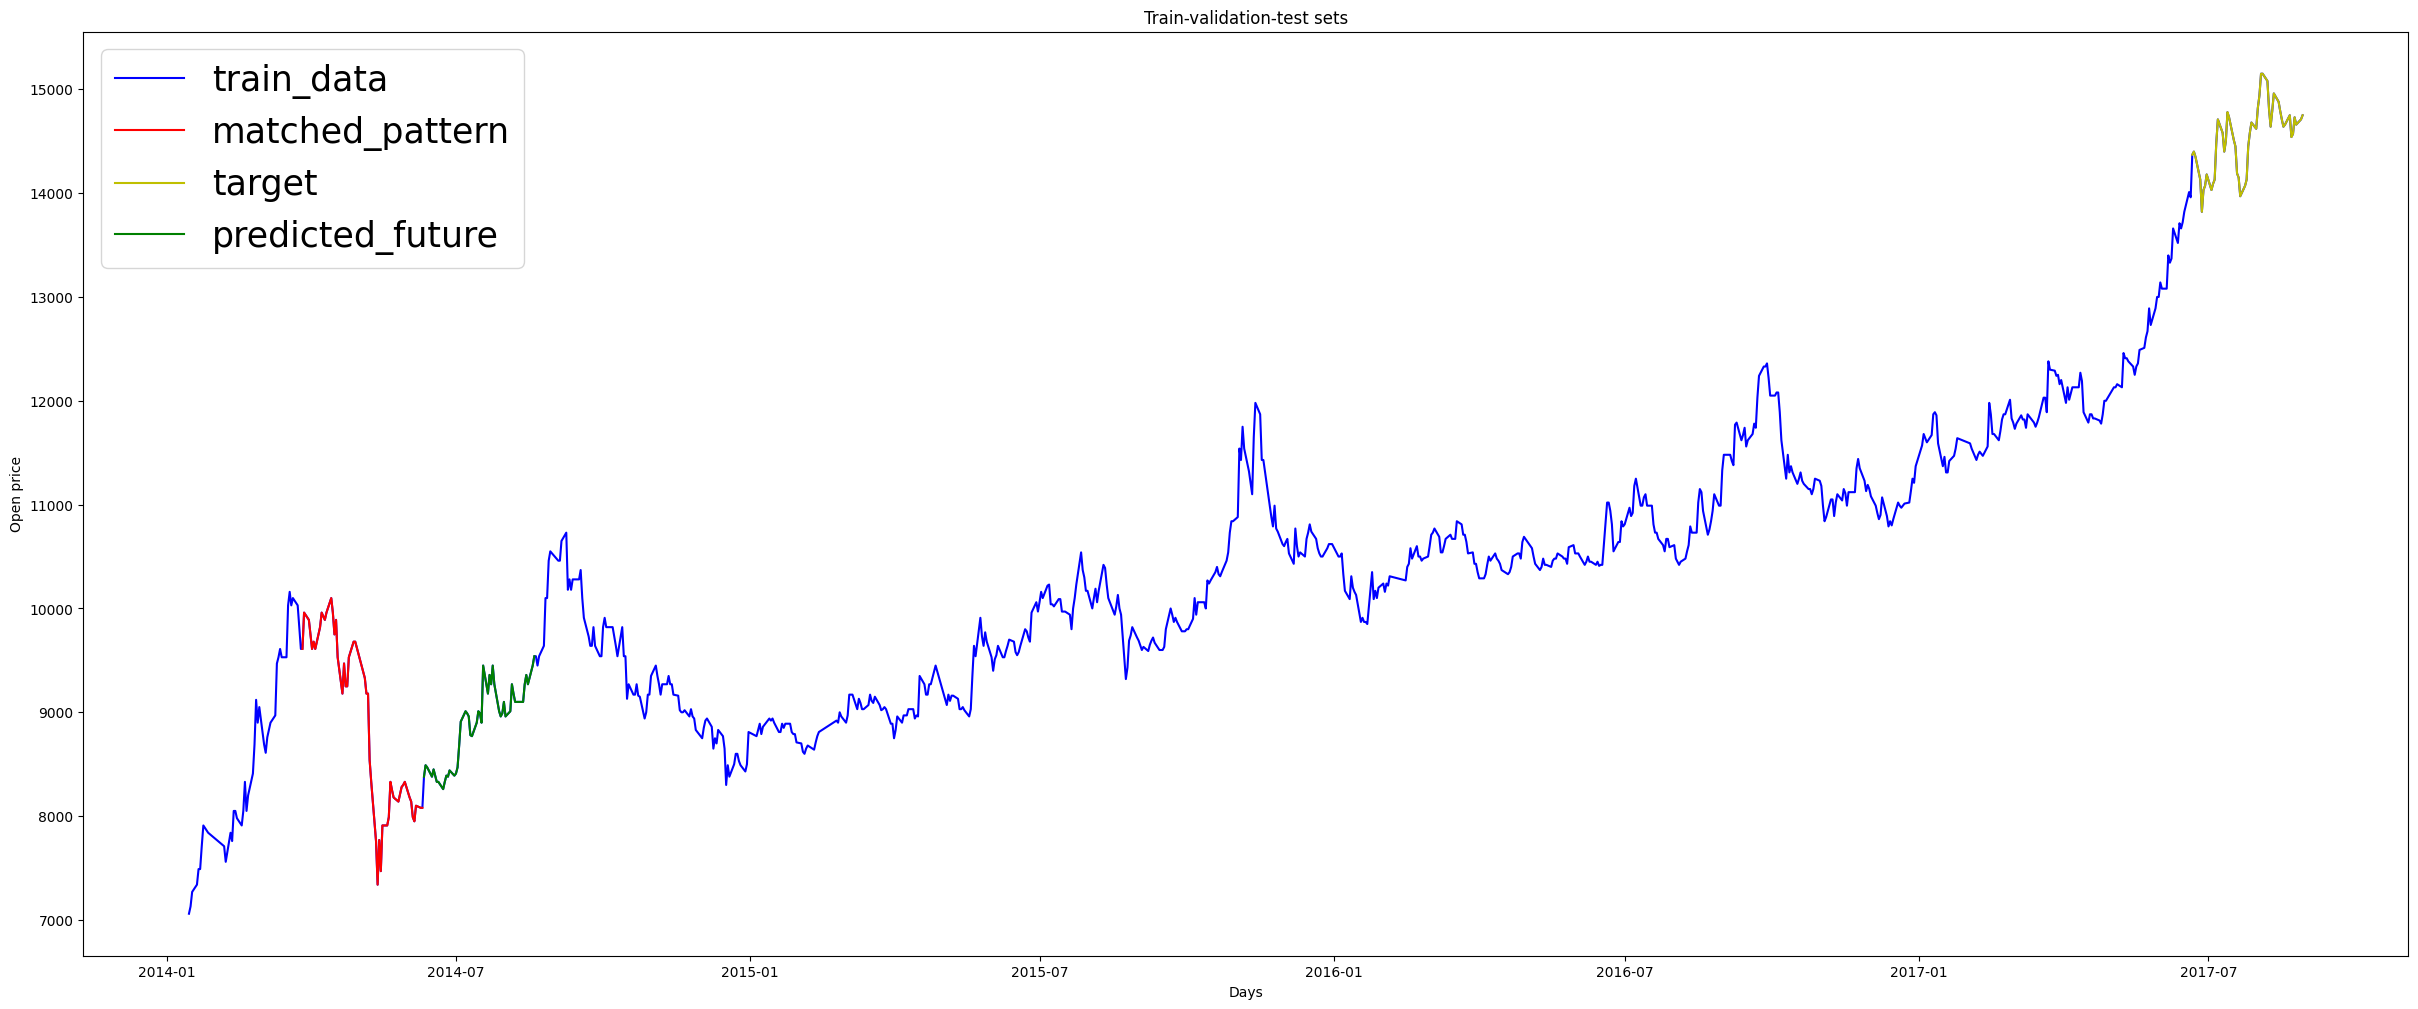

Predicted profit/loss is : 1460


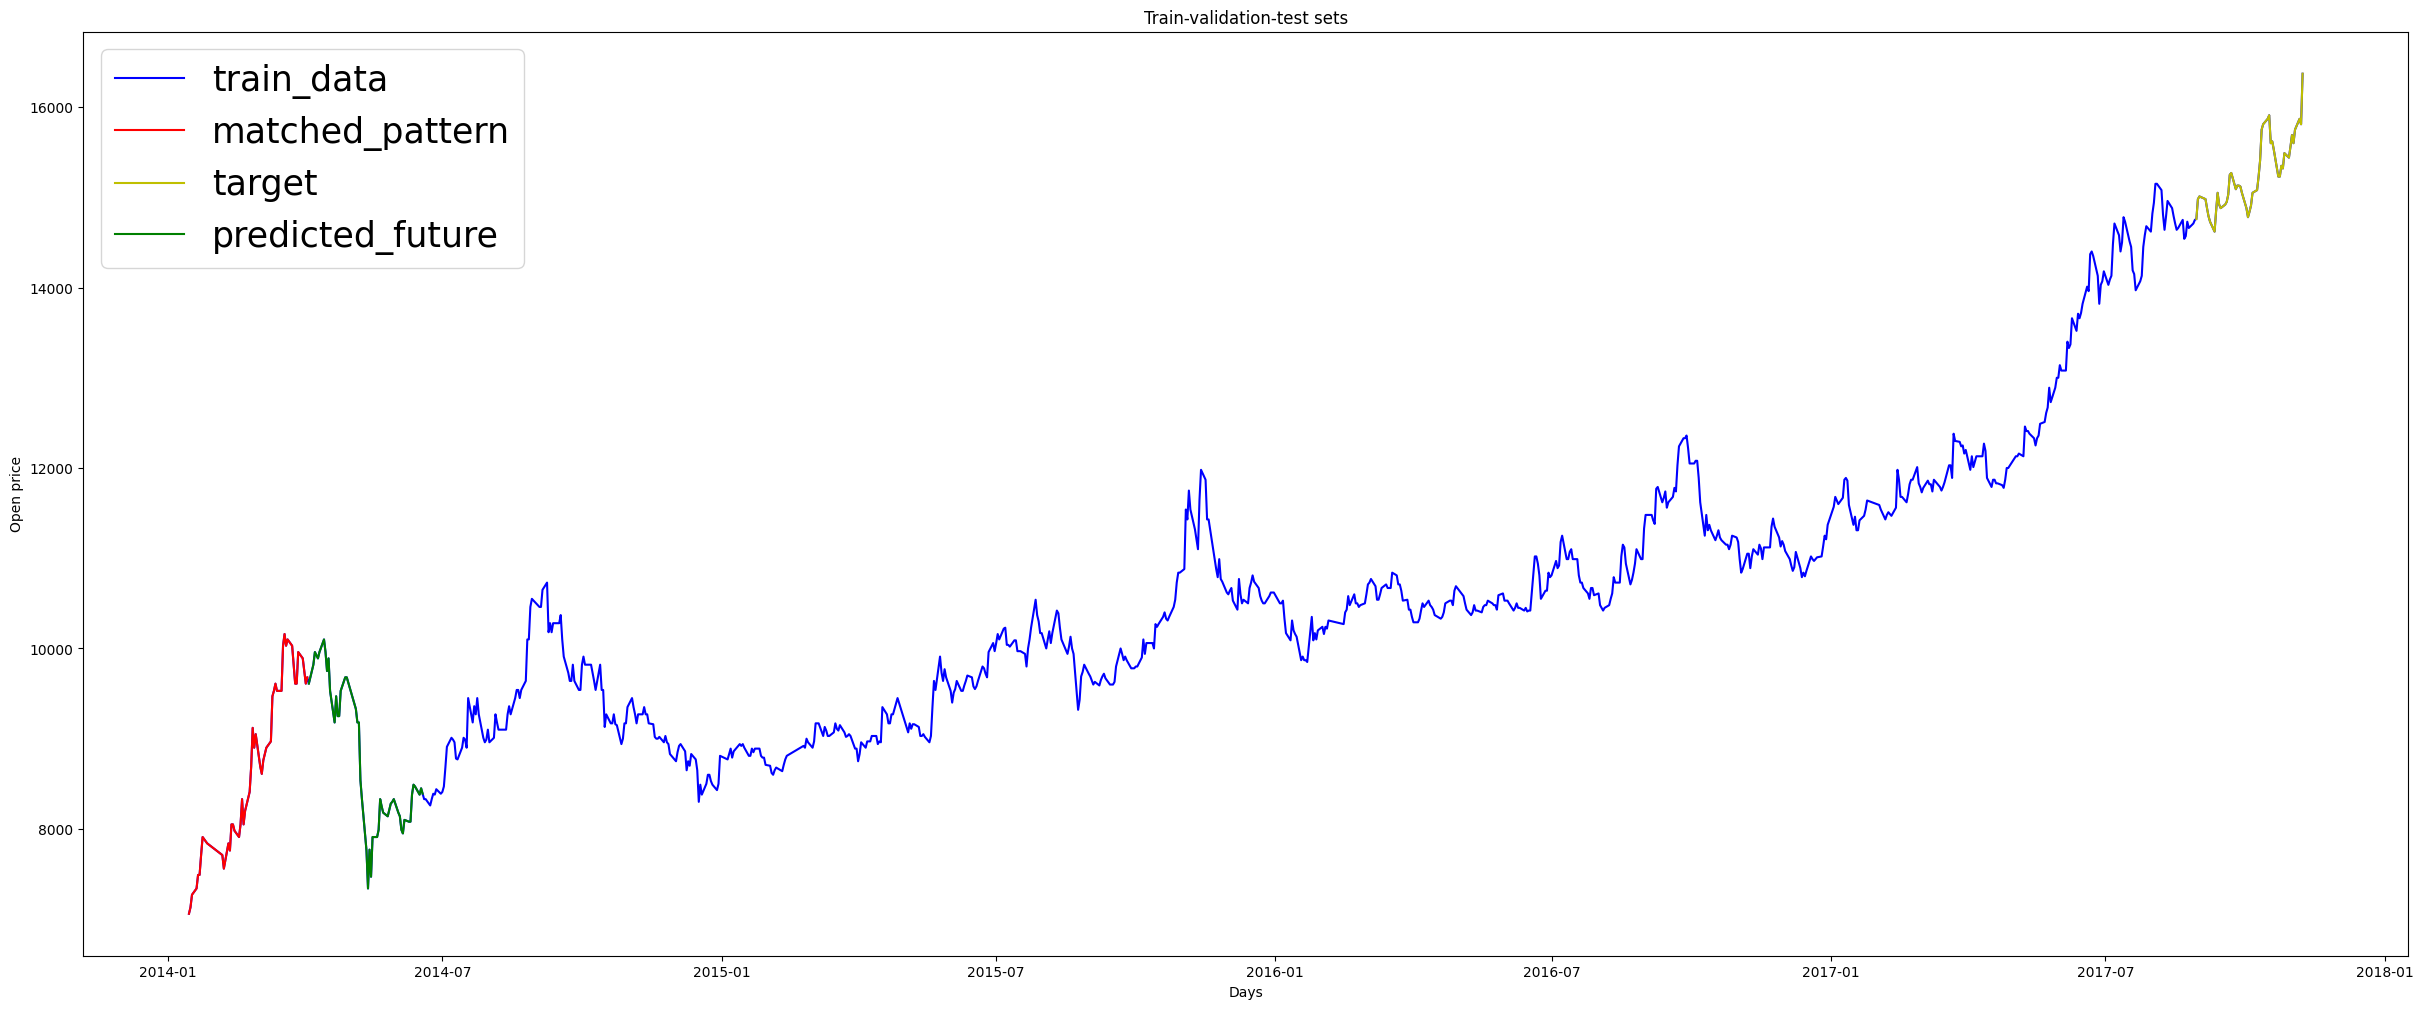

Predicted profit/loss is : -1290


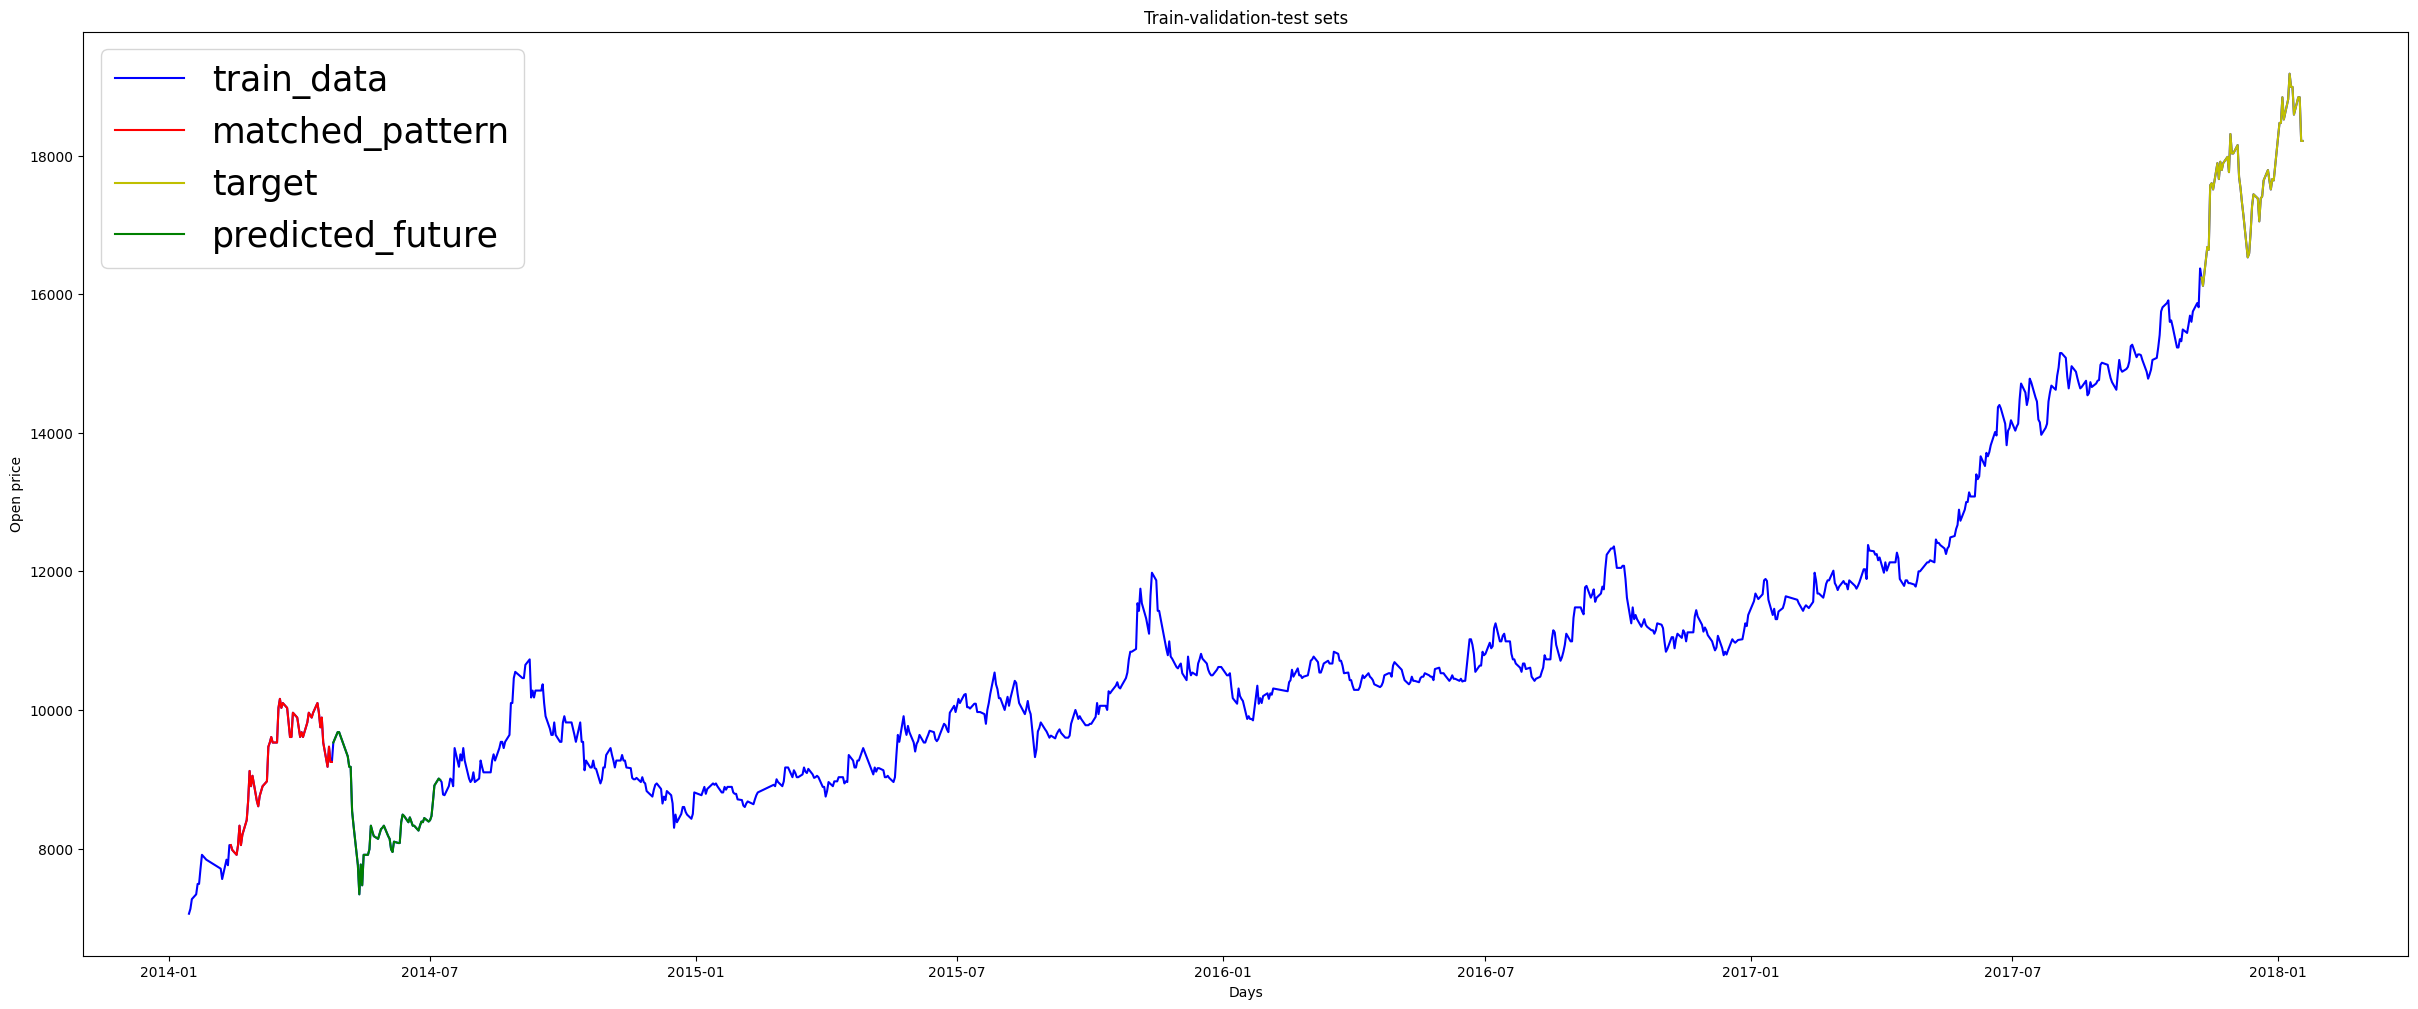

Predicted profit/loss is : -260


In [95]:
money = 1000
start = 500
window = 50
for i in range(10):
    pattern_start = pattern_matching(df_diff, start, window)
    plt.subplots(figsize =(30,12))
    plt.plot(df.iloc[0:start + window].index, \
             df[ticker].iloc[0:start + window], \
                label = "train_data", color = "b")
    
    plt.plot(df.iloc[pattern_start:pattern_start + window].index, \
             df[ticker].iloc[pattern_start:pattern_start + window], \
                label = "matched_pattern", color = "r")
    
    plt.plot(df.iloc[start:start+window].index, \
             df[ticker].iloc[start:start+window], \
                label = "target", color = "y")
    
    plt.plot(df.iloc[pattern_start + window:pattern_start + window*2].index, \
             df[ticker].iloc[pattern_start + window:pattern_start + window*2], \
                label = "predicted_future", color = "green")
    
    plt.xlabel("Days")
    plt.ylabel("Open price")
    plt.title("Train-validation-test sets")
    plt.legend(fontsize = 25)
    plt.show()
    
    predicted_earnings = df[ticker].iloc[pattern_start + window*2 - 1] - df[ticker].iloc[pattern_start + window - 1]
    print(f"Predicted profit/loss is : {predicted_earnings}")
    
    invest = input("Do you want to invest: Y/N")
    
    if invest == "Y":
        money -= df[ticker].iloc[start + window - 1]
        money += df[ticker].iloc[start + window*2 - 1]
    start += window
    